In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats 
from scipy.stats import shapiro 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("out.csv")

In [3]:
df = df.drop('screen', axis = 1)

In [4]:
y = df['mood']                          
list = ['Unnamed: 0','id','date','mood']
X = df.drop(list,axis = 1 )

# Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((887, 17), (381, 17), (887,), (381,))

In [6]:
print("Number of observations and dimensions in training set:", X_train.shape)
print("Number of observations and dimensions in test set:", X_test.shape)
print("Number of observations in training set:", y_train.shape)
print("Number of observations in test set:", y_test.shape)

Number of observations and dimensions in training set: (887, 17)
Number of observations and dimensions in test set: (381, 17)
Number of observations in training set: (887,)
Number of observations in test set: (381,)


# Scaling

In [7]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Scale the testing data
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns) 
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns) 

# Model Search

In [8]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

grid_models = [
    (LinearRegression(), [{}]), 
    (Ridge(), [{'alpha': np.logspace(-6, 1, 100), 'random_state': [0]}]),
    (Lasso(), [{'alpha': np.logspace(-6, 1, 100), 'random_state': [0]}]),
    (DecisionTreeRegressor(), [{'criterion': ['squared_error', 'friedman_mse', 'absolute_error'], 'random_state': [0]}]),
    (RandomForestRegressor(), [{'n_estimators': [100, 150, 200], 'criterion': ['squared_error', 'absolute_error'], 'random_state': [0]}]),
    (AdaBoostRegressor(), [{'n_estimators': [100, 150, 200], 'learning_rate': [0.1, 0.5, 0.8, 1], 'loss': ['linear', 'square', 'exponential'], 'random_state': [0]}]),
    (GradientBoostingRegressor(), [{'n_estimators': [100, 150, 200], 'criterion': ['friedman_mse', 'squared_error'], 'loss': ['squared_error', 'absolute_error', 'huber'], 'learning_rate': [0.1, 0.5, 0.8, 1], 'random_state': [0]}]),
    (XGBRegressor(), [{'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 150, 200], 'random_state': [0], 'eval_metric': ['rmse', 'mae']}])
]


In [9]:
from sklearn.model_selection import GridSearchCV

best_score = float('-inf')
best_model = None

for model, params in grid_models:
    grid = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    current_score = grid.best_score_
    print('{}:\nBest Score : {:.2f}%'.format(model.__class__.__name__, current_score * 100))
    print('Best Parameters : ', grid.best_params_)
    print('')
    print('----------------')
    print('')
    
    if current_score > best_score:
        best_score = current_score
        best_model = grid.best_estimator_

print('Best model overall:', best_model)


LinearRegression:
Best Score : -26.46%
Best Parameters :  {}

----------------

Ridge:
Best Score : -26.46%
Best Parameters :  {'alpha': 1e-06, 'random_state': 0}

----------------

Lasso:
Best Score : -26.46%
Best Parameters :  {'alpha': 0.0002983647240283337, 'random_state': 0}

----------------

DecisionTreeRegressor:
Best Score : -51.17%
Best Parameters :  {'criterion': 'absolute_error', 'random_state': 0}

----------------

RandomForestRegressor:
Best Score : -24.64%
Best Parameters :  {'criterion': 'absolute_error', 'n_estimators': 150, 'random_state': 0}

----------------

AdaBoostRegressor:
Best Score : -29.40%
Best Parameters :  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 150, 'random_state': 0}

----------------

GradientBoostingRegressor:
Best Score : -25.04%
Best Parameters :  {'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'squared_error', 'n_estimators': 100, 'random_state': 0}

----------------

XGBRegressor:
Best Score : -24.38%
Best Param

# Best Model

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Assuming GridSearch has been set up and executed
best_mse = grid.best_score_
print("Best MSE (negative):", best_mse)
print("Best MSE (positive):", -best_mse)
print("Best RMSE:", (-best_mse)**0.5)
print("Best Model:", best_model)


Best MSE (negative): -0.24375864518293813
Best MSE (positive): 0.24375864518293813
Best RMSE: 0.4937191966927538
Best Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def evaluation(x_train, x_test, best_model):
    model = best_model
    y_pred = model.predict(X_test)
# Calculate MSE
    mse = mean_squared_error(y_test, y_pred)

    # Calculate RMSE
    rmse = mse ** 0.5

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)

    # Calculate Explained Variance Score
    explained_variance = explained_variance_score(y_test, y_pred)


    # Print the results
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (Coefficient of Determination):", r2)
    print("Explained Variance Score:", explained_variance)


In [15]:
evaluation(X_train_scaled, X_test_scaled, best_model)

Mean Squared Error (MSE): 0.2432220668148455
Root Mean Squared Error (RMSE): 0.49317549291793233
Mean Absolute Error (MAE): 0.38616663881904284
R-squared (Coefficient of Determination): 0.5219996361139496
Explained Variance Score: 0.5269002293609938


# Improving RF

## Feature Selection

### RF Boruta

In [12]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature rankings
print("Feature ranking:")
for f in range(X_train_scaled.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]}) - {X_train_scaled.columns[indices[f]]}")


Feature ranking:
1. feature 2 (0.3718392252922058) - circumplex.valence
2. feature 8 (0.06566120684146881) - appCat.office
3. feature 5 (0.05090434104204178) - appCat.entertainment
4. feature 12 (0.05064002424478531) - appCat.unknown
5. feature 7 (0.05035388469696045) - appCat.game
6. feature 13 (0.04315326735377312) - appCat.utilities
7. feature 10 (0.042201440781354904) - appCat.social
8. feature 15 (0.039863988757133484) - call
9. feature 6 (0.038865964859724045) - appCat.finance
10. feature 9 (0.03728501871228218) - appCat.other
11. feature 3 (0.037062160670757294) - appCat.builtin
12. feature 16 (0.036373481154441833) - sms
13. feature 1 (0.03352189064025879) - circumplex.arousal
14. feature 4 (0.030450517311692238) - appCat.communication
15. feature 14 (0.027971088886260986) - appCat.weather
16. feature 11 (0.0251529049128294) - appCat.travel
17. feature 0 (0.01869957521557808) - activity


In [16]:
#del list

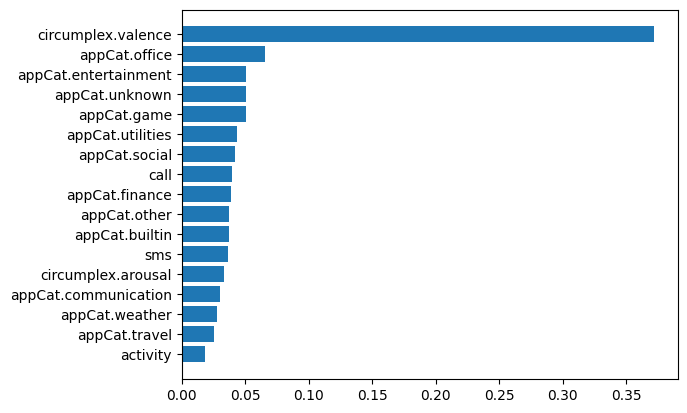

In [17]:
forest = best_model
forest.fit(X_train, y_train)
imp = {'Feature': X_train_scaled.columns.tolist(),'Importance':forest.feature_importances_ *100}
randomforest_features = pd.DataFrame(imp).sort_values(by='Importance', ascending=False)
f_i = list(zip(X_train_scaled.columns.tolist(),forest.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.show()

In [18]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

# Adjust RandomForest settings for quicker execution
rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42, n_jobs=-1)

# Set up Boruta with fewer estimators and a limited number of iterations
feat_selector = BorutaPy(rf, n_estimators=50, max_iter=100, verbose=2, random_state=1)

# Fit Boruta (use a subset of data if necessary)
feat_selector.fit(X_train_scaled.values, y_train)

# Output the results
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    status = "Passes the test" if feat_selector.support_[i] else "Doesn't pass the test"
    print(f"{status}: {X_train_scaled.columns[i]} - Ranking: {feat_selector.ranking_[i]}")


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	5
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	5
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	5
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	5
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	5
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	5
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	5
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	5
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	4
Rejected: 	9
Iteration:

In [19]:
import pandas as pd

# Assuming 'X' is your DataFrame of features and 'feat_selector' is your fitted BorutaPy object
confirmed_features = X.columns[feat_selector.support_].tolist()
tentative_features = X.columns[feat_selector.support_weak_].tolist()

# Combine confirmed and tentative features
boruta_features = confirmed_features + tentative_features

print("Confirmed Features:", confirmed_features)
print("Tentative Features:", tentative_features)
print("All Relevant Features (Confirmed + Tentative):", boruta_features)


Confirmed Features: ['activity', 'circumplex.arousal', 'circumplex.valence', 'appCat.communication', 'appCat.entertainment', 'appCat.office', 'appCat.social', 'call']
Tentative Features: []
All Relevant Features (Confirmed + Tentative): ['activity', 'circumplex.arousal', 'circumplex.valence', 'appCat.communication', 'appCat.entertainment', 'appCat.office', 'appCat.social', 'call']


In [20]:
X_train_b = X_train_scaled[boruta_features]
X_test_b = X_test_scaled[boruta_features]

In [21]:
X_test_b

,activity,circumplex.arousal,circumplex.valence,appCat.communication,appCat.entertainment,appCat.office,appCat.social,call
0,2.803912,-0.204835,1.909656,2.859749,0.935001,-0.191320,-0.319253,-0.784931
1,-1.154920,0.170917,1.215370,-0.593564,-0.532677,-0.191320,-0.040200,-0.784931
2,-0.629475,0.671919,-0.790345,-1.087671,-0.559851,-0.191320,-0.739862,-0.784931
3,-0.378893,1.373322,-1.561774,3.562322,-0.142719,-0.151748,1.322585,2.233457
4,3.825916,0.671919,0.752513,1.622134,-0.458228,-0.138509,-0.580890,4.245715
...,...,...,...,...,...,...,...,...
376,0.200860,-0.580587,1.523942,1.516288,-0.307212,-0.191320,-0.147732,0.221198
377,-1.040677,1.298172,-0.404631,-0.488310,-0.559851,-0.191320,-0.188932,-0.617243
378,0.124365,0.671919,0.752513,-0.877074,-0.217601,-0.191320,-0.739862,0.891951
379,-0.094600,-1.332090,-0.404631,1.977629,-0.559851,-0.191320,0.859703,-0.449555


### Retrain Model

In [22]:
evaluation(X_train_b, X_test_b, best_model)

Mean Squared Error (MSE): 0.2432220668148455
Root Mean Squared Error (RMSE): 0.49317549291793233
Mean Absolute Error (MAE): 0.38616663881904284
R-squared (Coefficient of Determination): 0.5219996361139496
Explained Variance Score: 0.5269002293609938


### Backeards Feature Selection

In [23]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming 'X' and 'y' are your original features and target variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)  # Convert back to DataFrame to retain column names


In [24]:
import statsmodels.api as sm

def backward_elimination(data, target, significance_level=0.05):
    features = data.columns.tolist()
    while len(features) > 0:
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]  # Exclude intercept
        max_p_value = p_values.max()
        if max_p_value >= significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
            print("Removed:", excluded_feature)
        else:
            break
    return features


In [25]:
selected_features = backward_elimination(X_scaled, y)
print("Selected features:", selected_features)


Removed: appCat.finance
Removed: sms
Removed: appCat.travel
Removed: appCat.communication
Removed: activity
Removed: appCat.builtin
Removed: appCat.game
Removed: circumplex.arousal
Selected features: ['circumplex.valence', 'appCat.entertainment', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'call']


In [26]:
# Filtering the training and testing datasets for selected features
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def evaluation(x_train, x_test, best_model):
    model = best_model
    y_pred = model.predict(X_test)
# Calculate MSE
    mse = mean_squared_error(y_test, y_pred)

    # Calculate RMSE
    rmse = mse ** 0.5

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)

    # Calculate Explained Variance Score
    explained_variance = explained_variance_score(y_test, y_pred)


    # Print the results
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (Coefficient of Determination):", r2)
    print("Explained Variance Score:", explained_variance)


In [28]:
evaluation(X_train_selected, X_test_selected, best_model)

Mean Squared Error (MSE): 0.2432220668148455
Root Mean Squared Error (RMSE): 0.49317549291793233
Mean Absolute Error (MAE): 0.38616663881904284
R-squared (Coefficient of Determination): 0.5219996361139496
Explained Variance Score: 0.5269002293609938
